# TP : Arbres de décision et fôrets aléatoires


## Résumé

Un arbre de décision est un modèle de classification hiérarchique : à chaque noeud de l'arbre
est associé un test sur une des dimensions $x_i$ de la forme $x_i \{\leq,~ >,~ = \} s$ ($s$ une valeur réelle) qui indique le noeud fils qui doit être sélectionné (par exemple pour un arbre binaire, le fils gauche quand le test est vrai, le fils droit sinon). A chaque feuille de l'arbre est associée une étiquette. Ainsi, la classification d'un exemple consiste en une succession de tests sur les valeurs des dimensions de l'exemple, selon un chemin dans l'arbre de la racine à une des feuilles. La feuille atteinte donne la classe prédite.

L'apprentissage de l'arbre s'effectue de manière récursive top-down : à chaque noeud, l'algorithme choisit le split vertical (seuillage
d'une variable) qui optimise une mesure d'homogénéité sur la partition obtenue (usuellement l'[entropie de shanon](http://fr.wikipedia.org/wiki/Entropie_de_Shannon#D.C3.A9finition_formelle) ou l'[index de Gini](http://fr.wikipedia.org/wiki/Coefficient_de_Gini) : l'entropie d'une partition est d'autant plus petite qu'une classe prédomine dans chaque sous-
ensemble de la partition, elle est nulle lorsque la séparation est parfaite).

Bien que l'algorithme pourrait continuer récursivement jusqu'à n'obtenir que des feuilles contenant un ensemble pur d'exemples (d'une seule classe), on utilise souvent des critères d'arrêts (pourquoi ? - nous y reviendrons lors de ce TP). Les plus communs sont les suivants :

+ le nombre d'exemples minimum que doit contenir un noeud

+ la profondeur maximale de l'arbre

+ la différence de gain de la mesure d'homogénéité entre le noeud père et les noeuds fils





## Prise en main sklearn, données artificielles


In [1]:
import numpy as np # module pour les outils mathématiques
import matplotlib.pyplot as plt # module pour les outils graphiques
from tools import * # module fourni en TP1
from sklearn import tree # module pour les arbres
from sklearn import ensemble # module pour les forets
from sklearn import linear_model # module pour les forets
from sklearn import cross_validation as cv
from IPython.display import Image
#import pydot

%matplotlib inline 

Tous les modeles d'apprentissage sous scikit fonctionnent de la manière suivante :

+ création du classifieur (ici  **cls=Classifier()**)

+ réglage des paramètres (par exemple la profondeur maximale, le nombre d'exemples par noeud)

+ apprentissage du classifieur par l'intermédiaire de la fonction **cls.fit(data,labels)** 

+ prediction pour de nouveaux exemples : fonction **cls.predict(data)**

+ score du classifieur (précision, pourcentage d'exemples bien classés) : fonction **cls.score(data,labels)**

Pour un arbre de décision, la classe est **tree.DecisionTreeClassfier()**.
Dans le cas des arbres de décisions, nous avons aussi la possibilité d'obtenir l'importance des variables, un score qui est d'autant plus grand que la variable est "utile" pour la classification.

precision :  0
precision (score) : 1.0
|---------X1<=-0.00
|         |---------(-1.0: 500, 1.0: 0)
|---------X1>-0.00
          |---------(-1.0: 0, 1.0: 500)



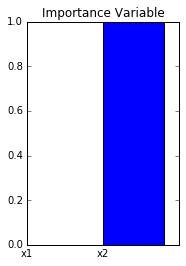

In [2]:
#Initialisation
data,y=gen_arti()
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=3 #profondeur maximale de 8
mytree.min_samples_split=1 #nombre minimal d'exemples dans une feuille de 1

#Apprentissage
mytree.fit(data,y)

#prediction
pred=mytree.predict(data)
print "precision : ", (1.*pred!=y).sum()/len(y)

#ou directement pour la precision : 
print "precision (score) : "  +` mytree.score(data,y)`

#Importance des variables :
plt.subplot(1,2,2)
plt.bar([1,2],mytree.feature_importances_)
plt.title("Importance Variable")
plt.xticks([1,2],["x1","x2"])

#Affichage de l'arbre
with file("mytree.dot","wb") as f:
    tree.export_graphviz(mytree,f)

###### Si graphviz n'est pas installe, la fonction suivante permet d'afficher un arbre
def affiche_arbre(tree):
    long = 10
    sep1="|"+"-"*(long-1)
    sepl="|"+" "*(long-1)
    sepr=" "*long
    def aux(node,sep):
        if tree.tree_.children_left[node]<0:
            ls ="(%s)" % (", ".join( "%s: %d" %(tree.classes_[i],int(x)) for i,x
 in enumerate(tree.tree_.value[node].flat)))
            return sep+sep1+"%s\n" % (ls,)
        return (sep+sep1+"X%d<=%0.2f\n"+"%s"+sep+sep1+"X%d>%0.2f\n"+"%s" )% \
                    (tree.tree_.feature[node],tree.tree_.threshold[node],aux(tree.tree_.children_left[node],sep+sepl),
                    tree.tree_.feature[node],tree.tree_.threshold[node],aux(tree.tree_.children_right[node],sep+sepr))
    return aux(0,"")
print(affiche_arbre(mytree))

In [ ]:
#Initialisation
data,y=gen_arti(data_type=0,nbex=1000,epsilon=0.5)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=6 #profondeur maximale de 5
mytree.min_samples_split=1 #nombre minimal d'exemples dans une feuille
#Apprentissage
mytree.fit(data,y)

#prediction
pred=mytree.predict(data)
print "precision : ", (1.*pred!=y).sum()/len(y)

#ou directement pour la precision : 
print "precision (score) : "  +` mytree.score(data,y)`

#Importance des variables :
plt.subplot(1,2,2)
plt.bar([1,2],mytree.feature_importances_)
plt.title("Importance Variable")
plt.xticks([1,2],["x1","x2"])
print(affiche_arbre(mytree))

### Paramètres pour les données générées artificiellement

On constate lorsque l'on fait varier les paramètres (profondeur maximale de l'arbre, minimums de données par feuilles) que la precision ne change que légèrement et que les prédictions sont toujours bonnes. Ces paramètres sont tout de même assez importants. En effet, pour éviter le sur-apprentissage et permettre la généralisation des prédictions, il faut que les noeuds contiennent un nombre minimum d'exemples et qu'il n'y ait pas de noeuds vides. De même, il ne faut pas que l'arbre soit trop profond. Il faut donc ajuster au mieux ces deux paramètres pour obtenir un arbre qui puisse classifier assez precisément (ne pas faire de sous-apprentissage) mais qui est un pouvoir de généralisation performant (donc éviter le sur-apprentissage).

On constate qu'avec 1000 données minimales par noeud (soit le nombre de données totales), la precision est de 0.95 alors que le sous-apprentissage est évident. Cette mesure de la precision n'est donc pas très bonne ni réaliste. La précision varie mais très peu. Il en est de même avec la profondeur. En ayant une profondeur de 1, et donc en ayant un fort sous-apprentissage la precision est de 0.96. La valeur de la precision n'est pas donc une mesure fiable de l'erreur.

L'arbre optimal (avec la meilleure précision, même si cette dernière n'est pas très fiable) a une profondeur de 6 et un nombre minimum de un exemple par noeud. Avec cette valeur, il faudrait verifier sur des données test pour éviter un sur-apprentissage probable.


In [ ]:
#On peut même classifier très bien l'echéquier, en augmentant la profondeur 
data,y=gen_arti(data_type=2,nbex=1000,epsilon=0.5)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=16 
mytree.min_samples_split=10 #nombre minimal d'exemples dans une feuille
#Apprentissage
mytree.fit(data,y)

#prediction
pred=mytree.predict(data)
print "precision : ", (1.*pred!=y).sum()/len(y)

#ou directement pour la precision : 
print "precision (score) : "  +` mytree.score(data,y)`

#Importance des variables :
plt.subplot(1,2,2)
plt.bar([1,2],mytree.feature_importances_)
plt.title("Importance Variable")
plt.xticks([1,2],["x1","x2"])
print(affiche_arbre(mytree))

## Paramètres pour l'echéquier

Dans ce cas, on constate que la precision est plus affectée par les paramètres de l'arbre. En effet, si l'on raccourcit trop l'arbre ou avec un nombre d'exemples par noeud trop important, la precision tombe à 54% soit proche d'un classifieur aléatoire.
On obtient une précision de 100% avec une profondeur de 23 et un nombre d'exemples minimales par noeud de 2. Cette situation doit comprendre un fort sur-apprentissage. On peut obtenir un score intéressant en limitant ce sur-apprentissage. En effet, avec une profondeur de 16 et un nombre d'exemples minimum de 10, on obtient un score de 84%.

De plus, on peut constater avec cette configuration que la répartition des exemples entre les classes est assez bon. Chaque classe contient à peu près 50% des données d'exemples, la répartition est donc assez juste sachant que dans l'echequier (notre cas) les données sont divisées équitablement en deux. La répartition confirme donc le bon score obtenu.Encore une fois, la prediction (non score) n'est pas influencée par ces paramètres.

Nous sommes donc arrivé à bien classer l'echequier, ce qui etait impossible avec un perceptron linéaire, il nous fallait un perceptron avec des projections.


In [ ]:
#traçons la précision (score) en fonction de la profondeur 
l = range(1,50)
score = []
data,y=gen_arti(data_type=2,nbex=1000,epsilon=1)
for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=i
    mytree.min_samples_split=1 #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    score.append(mytree.score(data,y))
    
plt.plot(l,score)
plt.title("Score en fonction de la profondeur (min_sample = 2, data_type = 2)")
plt.show()

In [ ]:
#traçons la précision (score) en fonction du minimum par feuille 

l = range(1,500)
score = []
data,y=gen_arti(data_type=2,nbex=1000,epsilon=1)
for i in l:
    
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=30
    mytree.min_samples_split=i #nombre minimal d'exemples dans une feuille
    #Apprentissage
    mytree.fit(data,y)

    #prediction
    pred=mytree.predict(data)

    score.append(mytree.score(data,y))
plt.plot(l,score)
plt.title("Score en fonction du nombre d'exemples par noeud (max_depth = 30, data_type = 2)")
plt.show()

## Influence des Paramètres sur la précision

Pour compléter notre étude, nous avons tracé l'influence du nombre d'elements par noeud et de la profondeur sur le score. Nous allons étudier les données prises de l'échéquier dans ce cas.

Nous pouvons constater que le score augmente de manière logarithmique selon la profondeur maximale pour atteindre une valeur asymptotique (score de 1) après une profondeur aux alentours de 25. 

Au contraire le score diminue de manière logarithmique lorsque l'on augmente le nombre d'elements par noeud jusqu'à atteindre une valeur seuil (score de 0.65) aux alentours de 100 données d'entrainement puis diminue plus lentement par seuil. 



## Validation croisée : sélection de modèle

Il est rare de disposer en pratique d'un ensemble de test (on préfère inclure le plus grand
nombre de données dans l'ensemble d'apprentissage). Pour sélectionner un modèle tout en considérant le plus grand nombre d'exemples possible pour l'apprentissage, on utilise généralement
une procédure dite de sélection par validation croisée. Pour chaque paramètrisation du problème,
une estimation de l'erreur empirique du classifieur appris est faîte selon la procédure suivante :

+ l'ensemble d'apprentissage $E_{app}$ est partitioné en $n$ ensembles d'apprentissage $\{E_i\}$

+ Pour $i=1..n$

  + l'arbre est appris sur $E_{app}$\ $E_i$

  + l'erreur en test $err(E_i)$ est évaluée sur $E_i$ (qui n'a pas servi à l'apprentissage à cette itération)

+ l'erreur moyenne $err=\frac{1}{n}\sum_{i=1}^n err(E_i)$ est calculée, le modèle sélectionné est celui qui minimise cette erreur


Ci-dessous quelques fonctions utiles pour la sélection de modèle :

### Score Test (Split et 10-Fold)

In [ ]:
data,y=gen_arti(data_type=2,nbex=1000,epsilon=0.5)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=20 
mytree.min_samples_split=2 #nombre minimal d'exemples dans une feuille

#permet de partager un ensemble en deux ensembles d'apprentissage et de test 
data_train,data_test,y_train,y_test=cv.train_test_split(data,y,test_size=0.3)
mytree.fit(data_train,y_train)
print "precision en test (split 30 %) : ", mytree.score(data_test,y_test)

#permet d'executer une n-validation croisée et d'obtenir le score pour chaque tentative
print "precision en test (10-fold validation) : ",cv.cross_val_score(mytree,data,y,cv=10).mean()


### Evolution des érreurs d'apprentissage et de test

#### Pour la profondeur

In [ ]:
#traçons la précision (score) en fonction de la profondeur 
l = range(1,30)
score_test = []
score_train = []
score_kfold = []
data,y=gen_arti(data_type=0,nbex=1000,epsilon=1)
data_train,data_test,y_train,y_test=cv.train_test_split(data,y,test_size=0.3)
mytree.fit(data_train,y_train)
for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=i
    mytree.min_samples_split=5 #nombre minimal d'exemples dans une feuille 5!!
    mytree.fit(data_train,y_train)
    score_train.append(mytree.score(data_train,y_train))
    score_test.append(mytree.score(data_test,y_test))
    score_kfold.append(cv.cross_val_score(mytree,data,y,cv=10).mean())
    
plt.plot(l,score_train)
plt.plot(l, score_test)
plt.plot(l, score_kfold)
plt.title("Score en fonction de la profondeur (min_sample = 1, data_type = 0)")
plt.show()

In [ ]:
#traçons la précision (score) en fonction de la profondeur 
l = range(1,30)
score_test = []
score_train = []
score_kfold = []
data,y=gen_arti(data_type=0,nbex=1000,epsilon=1)
data_train,data_test,y_train,y_test=cv.train_test_split(data,y,test_size=0.3)
for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=i
    mytree.min_samples_split=30 #nombre minimal d'exemples dans une feuille 20 !!
    mytree.fit(data_train,y_train)
    score_train.append(mytree.score(data_train,y_train))
    score_test.append(mytree.score(data_test,y_test))
    score_kfold.append(cv.cross_val_score(mytree,data,y,cv=10).mean())
    
plt.plot(l,score_train)
plt.plot(l, score_test)
plt.plot(l, score_kfold)
plt.title("Score en fonction de la profondeur (min_sample = 30, data_type = 0)")
plt.show()

Comme on l'avait dit précedemment, si le nombre d'exemples par noeud est trop faible, il y a un fort sur-apprentissage (cf premier graphique). Plus on augmente le nombre d'exemples par noeud, plus le sur-apprentissage diminue (écart entre le score d'apprentissage et le score de test). Lorsqu'il y a peu de sur-apprentissage, les deux courbes atteignent leur valeur asymptotique au bout d'une profondeur de 10.

On constate que les courbes d'erreur test par validation croisée et par 10-fold sont semblables. L'erreur par 10-fold est plus lisse car cette dernière est une moyenne.

Dans le cas où le sur-apprentissage est réduit, on se rend compte qu'il y a une valeur maximale du score de test selon la profondeur. En effet, pour une profondeur de 5, le sur apprentissage est assez faible et le score pour les données test est maximal.

#### Pour le nombre d'exemples par feuille

In [ ]:
l = range(1,50)
score_test = []
score_train = []
score_kfold = []
data,y=gen_arti(data_type=0,nbex=1000,epsilon=1)
data_train,data_test,y_train,y_test=cv.train_test_split(data,y,test_size=0.3)
for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=20
    mytree.min_samples_split=i #nombre minimal d'exemples dans une feuille
    mytree.fit(data_train,y_train)
    score_train.append(mytree.score(data_train,y_train))
    score_test.append(mytree.score(data_test,y_test))
    score_kfold.append(cv.cross_val_score(mytree,data,y,cv=10).mean())
    
plt.plot(l,score_train)
plt.plot(l, score_test)
plt.plot(l, score_kfold)
plt.title("Score en fonction du nombre d'exemples par noeud (max_depth = 30, data_type = 0)")
plt.show()

In [ ]:
l = range(1,50)
score_test = []
score_train = []
score_kfold = []
data,y=gen_arti(data_type=0,nbex=1000,epsilon=1)
data_train,data_test,y_train,y_test=cv.train_test_split(data,y,test_size=0.3)
for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=5
    mytree.min_samples_split=i #nombre minimal d'exemples dans une feuille
    mytree.fit(data_train,y_train)
    score_train.append(mytree.score(data_train,y_train))
    score_test.append(mytree.score(data_test,y_test))
    score_kfold.append(cv.cross_val_score(mytree,data,y,cv=10).mean())
    
plt.plot(l,score_train)
plt.plot(l, score_test)
plt.plot(l, score_kfold)
plt.title("Score en fonction du nombre d'exemples par noeud (max_depth = 30, data_type = 0)")
plt.show()

De manière analogue, ici, on constate que plus le nombre d'exemple par noeud augmente, plus le sur-apprentissage diminue. En effet avec 50 exemples par noeud l'ecart entre score d'apprentissage et test est assez faible et reste tout de même assez performant. 

On conste entre les deux graphiques, encore, l'importance de la profondeur. Dans le deuxieme cas, on a pris une profondeur de 5 conformément à l'etude sur la profondeur précédente.

#### Profondeur et jeu de données

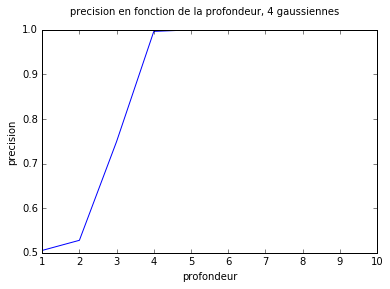

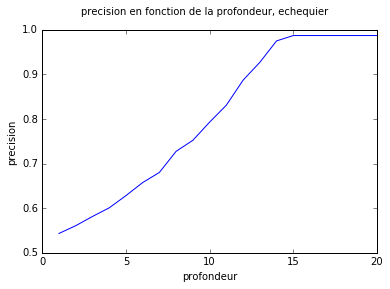

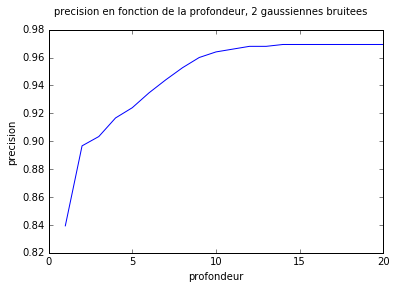

In [44]:
vec2=np.arange(1,11,1) 
#Graphique de la précision en fonction de la profondeur
precision_score=[]

data,y=gen_arti(data_type=1,nbex=1500)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
for i in vec2:
    mytree.max_depth=i #profondeur maximale de 5
    mytree.min_samples_split=10 #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    precision_score.append(mytree.score(data,y))

plt.figure().suptitle('precision en fonction de la profondeur, 4 gaussiennes')
plt.plot(vec2,precision_score)
plt.ylabel('precision')
plt.xlabel('profondeur')
plt.show()

vec2=np.arange(1,21,1) 
#Graphique de la précision en fonction de la profondeur
precision_score=[]

data,y=gen_arti(data_type=2,nbex=1500)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
for i in vec2:
    mytree.max_depth=i #profondeur maximale de 5
    mytree.min_samples_split=10 #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    precision_score.append(mytree.score(data,y))

plt.figure().suptitle('precision en fonction de la profondeur, echequier')
plt.plot(vec2,precision_score)
plt.ylabel('precision')
plt.xlabel('profondeur')
plt.show()

vec2=np.arange(1,21,1) 
#Graphique de la précision en fonction de la profondeur
precision_score=[]

data,y=gen_arti(data_type=0,nbex=1500,epsilon=1)
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
for i in vec2:
    mytree.max_depth=i #profondeur maximale de 5
    mytree.min_samples_split=10 #nombre minimal d'exemples dans une feuille
    mytree.fit(data,y)
    pred=mytree.predict(data)
    precision_score.append(mytree.score(data,y))

plt.figure().suptitle('precision en fonction de la profondeur, 2 gaussiennes bruitees')
plt.plot(vec2,precision_score)
plt.ylabel('precision')
plt.xlabel('profondeur')
plt.show()

La précision augmente toujours avec la profondeur de l'arbre. On constate par contre que cette evolution n'est pas identique selon le jeu de données.
Pour les 4 gaussiennes, il y a une valeur seuil de la profondeur pour avoir un score de 1. Cette valeur de seuil est de profondeur 3.
Pour l'echequier, l'arbre a besoin d'une profondeur plus importante pour séparer et la croissance de la precision selon la profondeur est quasi linéaire.
Pour deux gausiennes, la croissance est séparée en deux sections quasi-linéaire mais avec des pentes différentes, la rupture se fait pour une profondeur de 3.

## Classification données USPS

Tester sur les données USPS (en sélectionnant quelques sous-classes). Observer l'importance des variables. Afficher la matrice 2D de la variable importance de chaque pixel de l'image (avec **plt.imshow(matrix)**). Les résultats semble-t-ils cohérents ? 
Utiliser l'algorithme du perceptron fourni par sklearn (**linear_model.Perceptron**) ou le votre et comparer les résultats obtenus pour les poids.

Sur quelques exemples, comparer les performances des arbres et du Perceptron en utilisant la validation croisée pour calibrer au mieux vos modèles. 

Expérimenter également les fôrets aléatoires : c'est une méthode de baging très utilisée, qui consiste à considérer un ensemble d'arbres appris chacun sur un échantillonage aléatoire de la base d'exemples; la classification se fait par vote majoritaire (**enemble.RandomForestClassifier()**).

6


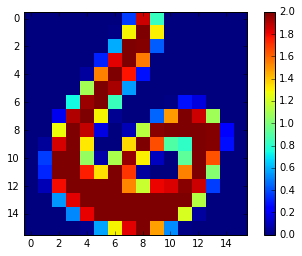

In [9]:
def  load_usps(filename):
    with open(filename ,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)
datax,y = load_usps("usps.txt")
plt.imshow(datax[0].reshape((16,16)),interpolation="nearest")
plt.colorbar()
print(y[0])

In [16]:
data_train,data_test,y_train,y_test=cv.train_test_split(datax,y,test_size=0.3)
print data_train.shape, data_test.shape

(5103, 256) (2188, 256)


#### Calibration du modèle

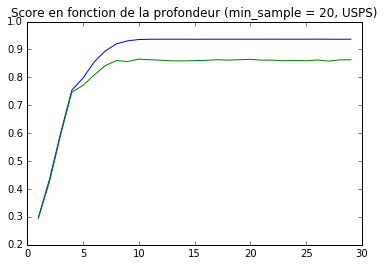

In [17]:
#traçons la précision (score) en fonction de la profondeur 
l = range(1,30)
score_test = []
score_train = []
#score_kfold = []

for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=i
    mytree.min_samples_split=20 #nombre minimal d'exemples dans une feuille 20 !!
    mytree.fit(data_train,y_train)
    score_train.append(mytree.score(data_train,y_train))
    score_test.append(mytree.score(data_test,y_test))
    #score_kfold.append(cv.cross_val_score(mytree,datax,y,cv=10).mean())
    
plt.plot(l,score_train)
plt.plot(l, score_test)
#plt.plot(l, score_kfold)
plt.title("Score en fonction de la profondeur (min_sample = 20, USPS)")
plt.show()

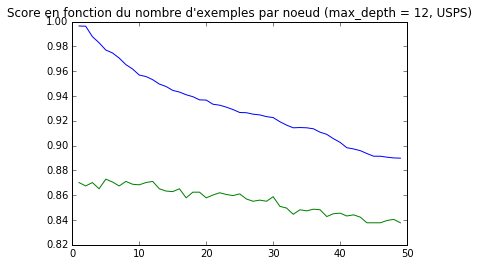

In [18]:
l = range(1,50)
score_test = []
score_train = []
#score_kfold = []
for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=12
    mytree.min_samples_split=i #nombre minimal d'exemples dans une feuille
    mytree.fit(data_train,y_train)
    score_train.append(mytree.score(data_train,y_train))
    score_test.append(mytree.score(data_test,y_test))
    #score_kfold.append(cv.cross_val_score(mytree,data,y,cv=10).mean())
    
plt.plot(l,score_train)
plt.plot(l, score_test)
#plt.plot(l, score_kfold)
plt.title("Score en fonction du nombre d'exemples par noeud (max_depth = 12, USPS)")
plt.show()

Pour calibrer le modèle, nous n'utilisons que la validation croisée par split car le temps de compilation pour k-fold est assez long. Finalement nous obtenons pour limiter le sur-apprentissage et obtenir le meilleur score :

Profondeur : 12

Nombre d'exemples par noeud : 20

#### Comparaison avec le perceptron

In [23]:
model = linear_model.Perceptron()
model.fit(data_train, y_train)
print '--> Perceptron '
print 'score train : ', model.score(data_train, y_train)
print 'score test : ', model.score(data_test, y_test)

mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=12
mytree.min_samples_split=20 
mytree.fit(data_train,y_train)
print '--> Arbre'
print "score train : ", mytree.score(data_train,y_train)
print 'score test : ', mytree.score(data_test, y_test)

--> Perceptron 
score train :  0.952968841858
score test :  0.928244972578
--> Arbre
score train :  0.926709778562
score test :  0.859689213894


Le score obtenu par le perceptron linéaire est meilleur que celui pour les abres. En effet le sur-apprentissage est plus faible pour le perceptron et le score général est plus élévé.

#### One Class vs All (Pour les 6)

In [38]:
datax,y = load_usps("usps.txt")
perc = linear_model.Perceptron()
mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=12
mytree.min_samples_split=20 

usps_6 = datax[y==6]
usps_not6 = datax[y!=6]
data_usps=np.vstack((usps_6,usps_not6))

label_6= -1*np.ones((len(usps_6),1))
label_not6=np.ones((len(usps_not6),1))
label=np.vstack((label_6,label_not6))

data_train,data_test,label_train,label_test=cv.train_test_split(data_usps,label,test_size=0.3)

mytree.fit(data_train,label_train)
perc.fit(data_train,label_train)
print 'score test Perceptron : ', perc.score(data_test,label_test)
print 'score test Arbres : ', mytree.score(data_test,label_test)

score test Perceptron :  0.987202925046
score test Arbres :  0.969378427788


/Users/alexandreattia/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


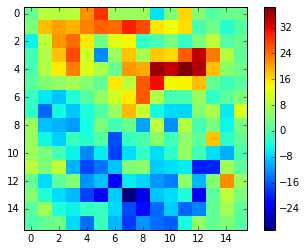

In [37]:
plt.imshow(perc.coef_.reshape((16,16)),interpolation="nearest")
plt.colorbar()

#### Random Forest

In [39]:
datax,y = load_usps("usps.txt")
data_train,data_test,y_train,y_test=cv.train_test_split(datax,y,test_size=0.3)

model = linear_model.Perceptron()
model.fit(data_train, y_train)
print '--> Perceptron '
print 'score train : ', model.score(data_train, y_train)
print 'score test : ', model.score(data_test, y_test)

mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=12
mytree.min_samples_split=20 
mytree.fit(data_train,y_train)
print '--> Arbre'
print "score train : ", mytree.score(data_train,y_train)
print 'score test : ', mytree.score(data_test, y_test)

rf=ensemble.RandomForestClassifier() #creation d'un arbre de decision
rf.fit(data_train,y_train)
print '--> Random Forest'
print "score train : ", rf.score(data_train,y_train)
print 'score test : ', rf.score(data_test, y_test)

--> Perceptron 
score train :  0.950421320792
score test :  0.929616087751
--> Arbre
score train :  0.937095825985
score test :  0.863345521024
--> Random Forest
score train :  0.998432294729
score test :  0.946069469835


Le bagging est méthode dans laquelle nn crée S ensembles de données de "même taille que l'original" créés à partir de rééchantillonnages aléatoire du jeu de données T avec des remplacements (n fois pour chaque ensemble de données). Cela se traduira par {T1, T2, ... TS} ensembles de données. 

Pour Random Forest, cela consiste à considérer un ensemble d'arbres appris chacun sur un échantillonage aléatoire de la base d'exemples. La classification se fait par vote majoritaire. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

On obtient donc logiquement un meilleur score que pour un arbre classique et on peut constater que l'on obtient également un meilleure score que pour le perceptron linéaire.


## Classification sur la base movielens 

La base movielens est une base de données issue d'imdb, qui contient des informations sur des films (le genre, l'année de production, des tags) et des notes attribuées par les utilisateurs. Elle est utilisée généralement pour la recommendation de films. Nous allons l'utiliser dans le cadre de la classification, afin de prédire si un film est bon ou mauvais, dans deux contextes :

+ en prenant en compte uniquement l'information sur le film et le score moyen du film

+ en prenant en compte l'information de l'utilisateur qui score le film

Télécharger l'[archive suivante](http://www-connex.lip6.fr/~baskiotisn/ARF15/imdb_extrait.pkl)

Le bloc de code suivant est utilisé pour  charger et prétraiter les données.

In [69]:
import cPickle
[data,id2titles, fields]=cPickle.load(file("imdb_extrait.pkl"))
datax = data[:,:32]
datay= np.array([1 if x[33]>6.5 else -1 for x in data]) # seuil de bon film a 6.5

In [106]:
print 'La taille de l\'ensemble est : ', datax.shape 

La taille de l'ensemble est :  (4587, 32)


Les informations suivantes sont stockées :

+ fields : liste des champs utilisés (28 genres, durée, couleur ou noir/blanc, année, budget,nombre de votes et rating)

+ data : une matrice, chaque ligne un film, chaque colonne un champs, 1 indique le genre s'applique au film, 0 non.

+ id2titles : pour chaque index de film, le titre du film

### Classification à partir de l'information unique du film
+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Expérimenter les arbres de décisions et le perceptron pour cette tâche. L'ordre de grandeur de chaque dimension joue-t-il un role ? sur quelles dimensions cela peut poser problème ? </font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Sur quelques paramètres, que remarquez vous sur l'erreur d'apprentissage et de test ?</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> La taille de l'ensemble de test joue-t-elle un rôle ?</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Tracer les courbes de ces deux erreurs en fonction de la profondeur. Que remarquez vous ? Quels sont les meilleurs paramètres pour l'erreur en apprentissage et en test ?</font>*

+ *<font style="BACKGROUND-COLOR: lightgray" color='red'> Quelles sont les variables les plus importantes ?  </font>*


In [103]:
data_train,data_test,y_train,y_test=cv.train_test_split(datax,datay,test_size=0.3)
model = linear_model.Perceptron()
model.fit(data_train, y_train)
print '--> Perceptron '
print 'score train : ', model.score(data_train, y_train)
print 'score test : ', model.score(data_test, y_test)

mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
mytree.max_depth=5
mytree.min_samples_split=30 
mytree.fit(data_train,y_train)
print '--> Arbre'
print "score train : ", mytree.score(data_train,y_train)
print 'score test : ', mytree.score(data_test, y_test)

--> Perceptron 
score train :  0.433956386293
score test :  0.429920116195
--> Arbre
score train :  0.751401869159
score test :  0.731299927378


In [94]:
print '--> Les 5 paramètres les plus importants sont : '
index=mytree.feature_importances_.argsort()[::-1][:5]
print [fields[x] for x in index]

--> Les 5 paramètres les plus importants sont : 
['Duree', 'budget', 'annee', 'Drama', 'Animation']


#### Erreurs selon la profondeur

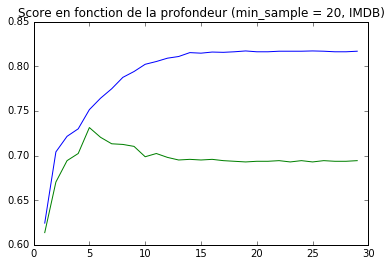

In [105]:
l = range(1,30)
score_test = []
score_train = []
#score_kfold = []

for i in l:
    mytree=tree.DecisionTreeClassifier() #creation d'un arbre de decision
    mytree.max_depth=i
    mytree.min_samples_split=30 #nombre minimal d'exemples dans une feuille 20 !!
    mytree.fit(data_train,y_train)
    score_train.append(mytree.score(data_train,y_train))
    score_test.append(mytree.score(data_test,y_test))
    #score_kfold.append(cv.cross_val_score(mytree,datax,y,cv=10).mean())
    
plt.plot(l,score_train)
plt.plot(l, score_test)
#plt.plot(l, score_kfold)
plt.title("Score en fonction de la profondeur (min_sample = 20, IMDB)")
plt.show()

La valeur optimale de la profondeur est de 5 avec un nombre d'exemples par noeuf de 20